#### SANDBOX for code development

In [2]:
#import packages
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from tqdm import tqdm

#import custom modules
import prep.prep_data as prep
import prep.prep_cv as cv

#magik
%matplotlib inline

In [4]:
df = prep.read_then_clean('../data/housing_data.csv',
                          ['housing_roof', 'housing_wall', 'housing_floor'],
                          ['MACRO_DHS'])

~begin reading
data read!
~begin cleaning
data clean!
~applying filter


In [5]:
df_clean = prep.remove_garbage_codes(df, 
                                     ['housing_roof', 'housing_wall', 'housing_floor'],
                                     ['nan', 'other', 'not a dejure resident', 'not dejure resident'])
df_clean = prep.extract_ranking(df_clean, ['housing_roof_num', 'housing_wall_num', 'housing_floor_num'])
df_clean = prep.remove_garbage_codes(df_clean, 
                                     ['housing_roof_rank', 'housing_wall_rank', 'housing_floor_rank'],
                                     ['4', '5', '6', '7', '8', '9', 'n'])
train_list = cv.cv_censor_col(df_clean, 'housing_roof_rank', .2, 'N', 5)

{'nan': nan, 'other': nan, 'not a dejure resident': nan, 'not dejure resident': nan}
removing garbage from  housing_roof
removing garbage from  housing_wall
removing garbage from  housing_floor
defining ranking for  housing_roof_num
defining ranking for  housing_wall_num
defining ranking for  housing_floor_num
{'4': nan, '5': nan, '6': nan, '7': nan, '8': nan, '9': nan, 'n': nan}
removing garbage from  housing_roof_rank
removing garbage from  housing_wall_rank
removing garbage from  housing_floor_rank
sampling df, iteration # 0
sampling df, iteration # 1
sampling df, iteration # 2
sampling df, iteration # 3
sampling df, iteration # 4


In [6]:
str_list, idk_strings = build_corpus(train_list[1], 'housing_roof_rank', 'housing_roof', ['1', '2', '3'])

NameError: name 'build_corpus' is not defined

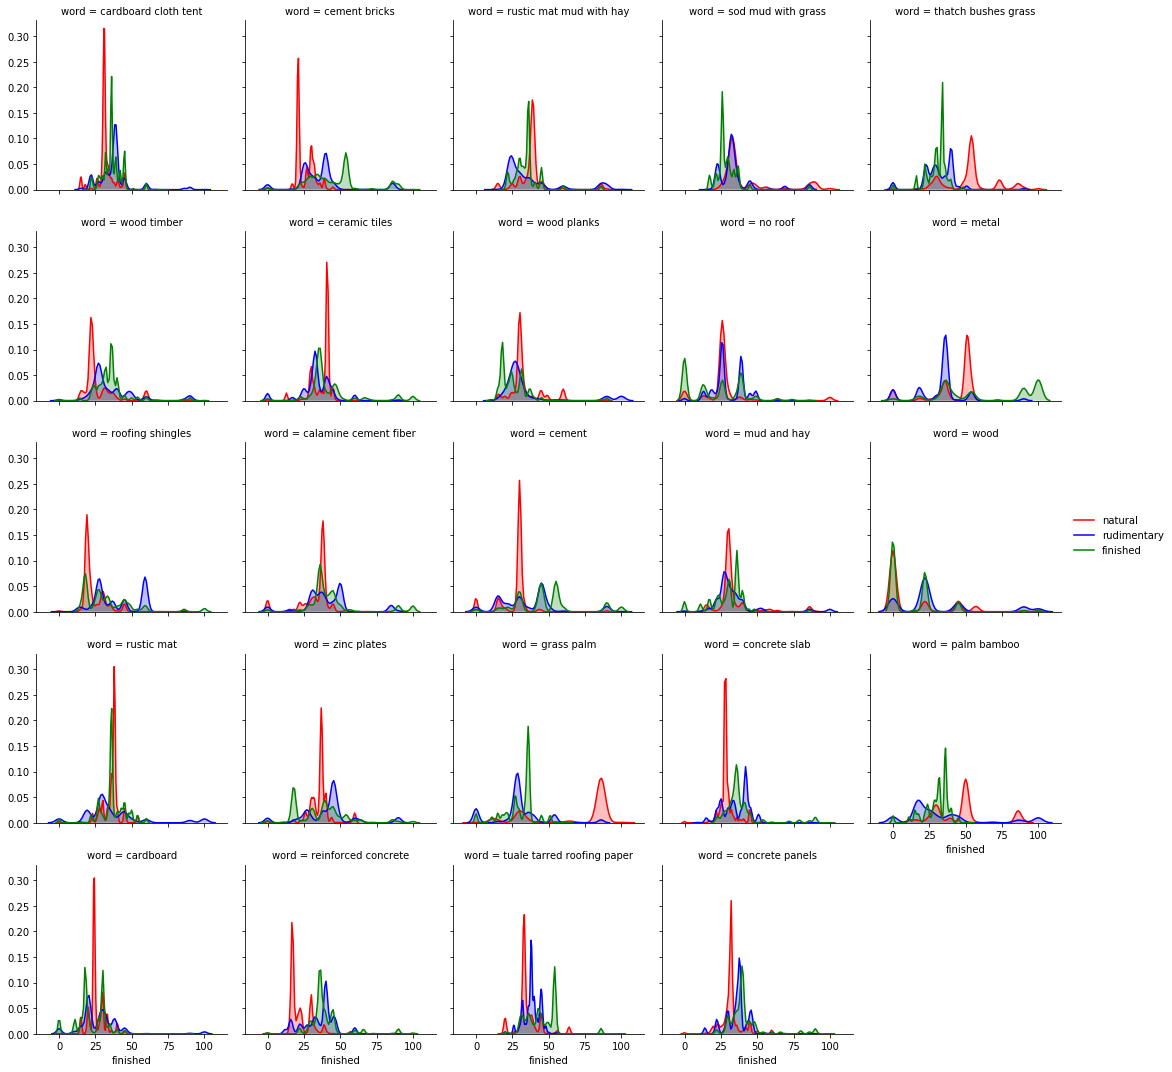

In [35]:
g = sns.FacetGrid(distrib, col="word", col_wrap=5, height=3)

var_list=['natural', 'rudimentary', 'finished']
color_list={'natural':'r', 'rudimentary':'b', 'finished':'g'}
variant = ""

for var in var_list:
    ('plotting...', var)
    g = g.map(sns.kdeplot, var+variant, shade=True, color=color_list[var])   
g = g.add_legend()

In [38]:
distrib = fuzzy_scan(idk_strings, str_list)

analyzing... cardboard cloth tent
analyzing... cement bricks
analyzing... rustic mat mud with hay
analyzing... sod mud with grass
analyzing... thatch bushes grass
analyzing... wood timber
analyzing... ceramic tiles
analyzing... wood planks
analyzing... no roof
analyzing... metal
analyzing... roofing shingles
analyzing... calamine cement fiber
analyzing... cement
analyzing... mud and hay
analyzing... wood
analyzing... rustic mat
analyzing... zinc plates
analyzing... grass palm
analyzing... concrete slab
analyzing... palm bamboo
analyzing... cardboard
analyzing... reinforced concrete
analyzing... tuale tarred roofing paper
analyzing... concrete panels
analyzing... ruberoid asbest
analyzing... slate
analyzing... tol kir
analyzing... thatch palm leaf
analyzing... metallique
analyzing... tuiles
analyzing... vegetal
analyzing... autre
analyzing... local tiling
analyzing... tiles slate
analyzing... zinc cement fiber
analyzing... sod
analyzing... straw
analyzing... tole
analyzing... earth
anal

In [9]:
%%file ./model/fuzzy.py

#define function to replace meaningless values with NaNs
# def extract_ranking(df, vars_to_clean):
#     """This helper function is used to 

#     Args:
#     df (pandas df): This is a pandas df that has 
#     dep_var (str): This is the name of a column

#     Returns:
#         df_out: 
        
#     TODO: ?

#     """
    
#     #import necessary modules
#     import pandas as pd
#     import numpy as np
#     import re
#     from fuzzywuzzy import fuzz
#     from fuzzywuzzy import process
    
#     df_out = df.copy()

#     #output a clean dataset
#     return 

def build_corpus(df, rank_var, str_var, rank_list):
    
    out = []
    
    for x in rank_list:
        print("building corpus for rank #", x)
        out.append(df[df[rank_var]==x][str_var].values)    

    print("extracting unknown strings")
    other = df[~df[rank_var].isin(rank_list)][str_var].unique()
    other = other[~pd.isnull(other)] #cant classify NaN

    return(out, other)

def fuzzy_scan(unknown_list, corpus_list):

    distrib = []

    #loop over each unknown string
    for x in range(len(unknown_list)): 
        unknown_str = unknown_list[x]
        print('analyzing...', unknown_str)

        out = []
        #loop over each corpus to compute similarity scores for all words in a given housing quality score
        for y in range(len(corpus_list)):
            print('~>corpus#', y)
            corpus = corpus_list[y]


            scores = []
            #loop over each word and compute the similarity score
            for z in tqdm(range(len(corpus))): #tqdm=progress bar
                scores.append(fuzz.WRatio(unknown_str, corpus[z]))

            out.append(scores) #append scores to create a distribution for the entire corpus

        #append distributions of scores
        distrib.append(pd.DataFrame({'word': unknown_str, 
                                     'natural':pd.Series(out[0]), 
                                     'rudimentary':pd.Series(out[1]), 
                                     'finished':pd.Series(out[2]) #note series method used to overcome differing lengths
                                    }))


    return(pd.concat(distrib))

def fuzzy_transform(df, var_list, grouping, fx, stub):

    for var in var_list:

        print('calculating prob for...', var)

        kwargs = {var+stub : lambda x: x[var]/x.groupby(grouping)[var].transform(fx)}
        df = df.assign(**kwargs)

    return(df)

In [ ]:
#command scraps
#pd.crosstab(train_list[1]['housing_wall_rank'], columns='count')


#fuzzy_scan scraps
distrib = []
match = []

for x in range(len(idk_strings[1:50])): 
    unknown_string = idk_strings[x]
    print('analyzing...', unknown_string)
    
    #set lists to store loop results
    nat = []
    rud = []
    fin = []
               
    for y in range(len(nat_strings)):
        nat.append(fuzz.WRatio(unknown_string, nat_strings[y]))
        rud.append(fuzz.WRatio(unknown_string, rud_strings[y]))
        fin.append(fuzz.WRatio(unknown_string, fin_strings[y]))
    
    #append distributions of scores
    distrib.append(pd.DataFrame({'word': unknown_string, 'natural':nat, 'rudimentary':rud, 'finished':fin}))
    
    #pull best matches
    #note that extractOne returns an array, first item is match/second the ratio
    match.append(pd.DataFrame({'word': unknown_string, 
                               'natural':process.extractOne(unknown_string, nat_strings)[0], 
                               'rudimentary':process.extractOne(unknown_string, rud_strings)[0], 
                               'finished':process.extractOne(unknown_string, fin_strings)[0]}, 
                              index=[0])) 

distrib = pd.concat(distrib)
distrib = fuzzy_transform(distrib, ['natural', 'rudimentary', 'finished'], 'word', 'sum', '_prob')
match = pd.concat(match)

In [ ]:
#%%file ./prep/prep_cv.py

#define necessary helper functions
def cv_censor_col(df, colname, pct=.2, weight_var=None, reps=5):
    
    """This function is used to create pandas dfs where a specified % of the values in a column have been censored
    and replaced with NaN, so that they can be predicted in a cross-validation methodology. It returns a list of such
    dfs that is the length of the reps argument.

    Args:
        df (pandas df): This is a pandas df that has columns with garbage values to be removed.
        colname (str): This is a string indicating the name of a column that you want to censor and later predict.
        pct (float): This is a value between 0-1 that indicates the fraction of values you want to censor. Default = 20%
        weight_var (str): This is a string indicating the column name is used to weighted the sample. Default = No weight.
        reps (int): This is an integer indicating the number of different training datasets to create. Default = 5x

    Returns:
        df_clean: This function returns a pandas df where the garbage codes have been replaced with NaN.
        
    TODO: ?

    """
    
    #import packages
    import pandas as pd
    import numpy as np
    
    out = []
    
    for x in range(reps):
            
        print("sampling df, iteration #", x)
    
        #first archive your old column in order to test later
        new_df = df.copy()
        new_df[colname + '_og'] = new_df[colname]
        df['train'] = 1 #set column to specify whether training or test data

        #draw a weighted sample if weight var is specified
        if weight_var != None:
            df_censor = new_df.sample(frac=pct, weights=weight_var)
        else:
            df_censor = new_df.sample(frac=pct)
            
        #now replace the sampled column with missing values in order to try and predict
        #note that replacement is only done on the sampled indices
        df_censor['train'] = 0 #note that this sample is no longer training data (it is test)
        df_censor[colname] = "replace_me"
        new_df.update(df_censor, overwrite=True)
        new_df[colname].replace("replace_me", np.nan, inplace=True)
        #TODO unsure if this is pythonic method but it seems like df.update won't replace values with NaN, 
        #as such, need to do this workaround
        
        #store the result (df with columns censored)
        out.append(new_df)
    
    #return the list of sampled dfs
    return(out)

In [ ]:
%%file ./prep/prep_data.py
#define necessary helper functions
def clean_text(text):
    """This function is used to clean a selection of text. 
    It uses several regular expressions and built in text commands in order to remove commonly seen 
    errors,
    nonsense values, 
    punctuation, 
    digits, and 
    extra whitespace.

    Args:
        text (str): This is a text value that needs to be cleaned.

    Returns:
        text: This function returns a cleaned version of the input text.
        
    TODO: Add functionality to impute a selected value for NaN or missing values?

    """
    #import necessary modules
    import re
    
    #force all vals in series to string
    text = str(text)
    
    #first remove uppercase
    text = text.lower()
    
    #remove common errors
    text = re.sub(r"\[.]", "", text) 
    text = re.sub(r"\<ff>", "", text)   
    text = re.sub(r"\<fb>", "", text)
    text = re.sub(r"\<a\d>", "", text)   
    text = re.sub(r"\<c\d>", "", text)   
    text = re.sub(r"\<d\d>", "", text)
    text = re.sub(r"\<e\d>", "", text)   
    text = re.sub(r"\<f\d>", "", text)   
    text = re.sub(r"\d+\.", "", text)

    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)   

    # replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    
    # remove any remaining digit codes
    text = re.sub(r"\d+", "", text)
    
    # remove any leading/trailing/duplicate whitespace
    text = re.sub(' +', ' ', text.strip())
    
    return text
    
#define master function
def read_then_clean(file_path, vars_to_clean, filter_series=None):
    """This is the master function for this module. It uses the previously defined helper functions,
    in order to output a clean dataset for user. It reads in a selected .csv file from a given filepath,
    and applies the previously defined cleaning functions to a list of variables provided by user.
    
    It can also optionally filter the df based on the survey series or TODO language.

    Args:
        file_path (str): This is a string indicating which file that you want to read in.
        vars_to_clean (list): This is a list of strings that indicate which columns you want to clean.
        filter_series (list): This is a list of strings that indicate which survey series to keep.

    Returns:
        df_clean: This is a pandas df that has columns of text values that have been cleaned using the helper function.
        
    TODO: Is it better to return an obj called df_clean to be more explicit to user?

    """
    #import necessary modules
    import pandas as pd
    import numpy as np
    
    #read in your data
    print("~begin reading")
    df_raw = pd.read_csv(file_path, low_memory=False)
    min_nrow = len(df_raw) #save the row count to test after cleaning and verify that rows are not being dropped
    print("data read!")
    
    #cleanup
    print("~begin cleaning")
    df_clean = df_raw.copy()
    for var in vars_to_clean:
        df_clean[var] = df_clean[var].apply(clean_text)
    print("data clean!")
    
    # Verify that the minimum rowcount continues to be met
    if len(df_clean) < min_nrow:
        class RowCountException(Exception):
            """Custom exception class.
            
            This exception is raised when the minimum row is unmet.

            """
            pass
        
        raise RowCountException("Minimum number of rows were not returned after cleaning. Data is being lost!")
        
    # Filter data if filter arguments are provided by user
    if filter_series != None:
        print("~applying filter")
        df_clean = df_clean[df_clean['survey_series'].isin(filter_series)]
        
    #output a clean dataset
    return df_clean

#define function to replace meaningless values with NaNs
def remove_garbage_codes(df, vars_to_clean, garbage_list):
    """This helper function is used to remove garbage values from a pandas df, replacing them with NaN.

    Args:
    df (pandas df): This is a pandas df that has columns with garbage values to be removed.
    vars_to_clean (list): This is a list of strings that indicate which columns you want to clean.
    garbage_list (list): This is a list of strings that indicate which garbage values to replace with NaN

    Returns:
        df_clean: This function returns a pandas df where the garbage codes have been replaced with NaN.
        
    TODO: ?

    """
    
    #import necessary modules
    import pandas as pd
    import numpy as np
    
    df_clean = df.copy()
    
    # build dictionary to map all garbage values to NaN
    garb_dict = {}
    for string in garbage_list:
        garb_dict[string] = np.nan
    
    print(garb_dict)
    
    for var in vars_to_clean:
        print("removing garbage from ", var)
        df_clean[var].replace(garb_dict, inplace=True)
        
    #output a clean dataset
    return df_clean

#define function to replace meaningless values with NaNs
def extract_ranking(df, vars_to_clean):
    """This helper function is used to extract the ordinal rankings from numerical coding.

    Args:
    df (pandas df): This is a pandas df that has columns with garbage values to be removed.
    vars_to_rank (list): This is a list of strings that indicate which columns you want to extract ranks from.

    Returns:
        df_out: This function returns a pandas df with new vars added with the ordinal rank cols defined.
        
    TODO: ?

    """
    
    #import necessary modules
    import pandas as pd
    import numpy as np
    import re
    
    df_out = df.copy()
    
    for var in vars_to_clean:
        print("defining ranking for ", var)
        newcol = re.sub("_num", "_rank", var) 
        df_out[newcol] = df_out[var].astype(str).str[0]

    #output a clean dataset
    return df_out

In [ ]:
%%file ./tests/test_prep.py
#write tests
"""This is a module used to test a module: "prep.py" and its relevant functions read_then_clean and clean_text

read_then_clean is a function that takes a csv with messy string values and 
creates then cleans a pandas df
using clean_text

This module tests that function by ensuring that it returns expected exceptions and
does not contain unexpected values.
"""
# import packages
import pytest
import pandas as pd
import re

#import custom modules fpr testing
import prep.prep_data as prep

#set globals for tests
FILEPATH = '../data/housing_data.csv'
CLEAN_COLS = ['housing_roof', 'housing_wall', 'housing_floor']
DIGITS = str([str(x) for x in range(100 + 1)])
PUNCT = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
SPACE = '     '

# if you compile the regex string first, it's even faster
re_dig = re.compile('\d')
re_punct = re.compile('\W+')
re_white = re.compile(' +')

def test_globals():
    """This function tests that the test globals are properly defined.
    """
    #assert that digits are removed
    assert re_dig.search(DIGITS) != None, "global doesn't contain digits!" 
    #assert that punctutation is removed
    assert re_punct.search(PUNCT) != None, "global doesn't contain punctuation!"
    #assert that excessive whitespace is removed
    assert re_white.search(SPACE) != None, "global doesn't contain whitespace!"
    

def test_clean_text():
    """This function tests that the clean text function is doing its job.
    """
    #assert that digits are removed
    assert re_dig.search(prep.clean_text(DIGITS)) == None, "clean_text did not remove the digits from test global." 
    #assert that punctutation is removed
    assert re_punct.search(prep.clean_text(PUNCT)) == None, "clean_text did not remove the punctuation from test global."
    #assert that excessive whitespace is removed
    assert re_white.search(prep.clean_text(SPACE)) == None, "clean_text did not remove the whitespace from test global."

# This is our base dataset and it needs to be cleaned properly. The second argument specifies
# the cols with string values that we want to be cleaned.


#TODO, how to cause read_then_clean to raise the row count exception??
def test_read_then_clean():
    """This function tests that a custom exception called RowCountException
    will be returned when more than 1k rows are expected.
    """
    with pytest.raises(Exception) as err:
        test_df = prep.read_then_clean(FILEPATH,
                                       CLEAN_COLS)
    assert 'RowCountException' in str(err) #verify that your custom error is returned

In [ ]:
#scraps
DIGITS = str([str(x) for x in range(100 + 1)])
PUNCT = "xx"
#PUNCT = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
SPACE = '     '

(DIGITS)
test_globals()
#look at some of the clean values
df_raw.housing_floor.unique().tolist()
clean_text('32. vinyl_asphalt')

In [ ]:
#define test globals
DIGITS = str([str(x) for x in range(100 + 1)])
PUNCT = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
SPACE = '     '

# if you compile the regex string first, it's even faster
re_dig = re.compile('\d')
re_punct = re.compile('\W+')
re_white = re.compile(' +')

def test_globals():
    """This function tests that the test globals are properly defined.
    """
    #assert that digits are removed
    assert re_dig.search(DIGITS) != None, "Global doesn't contain digits!" 
    #assert that punctutation is removed
    assert re_punct.search(PUNCT) != None, "Global doesn't contain punctuation!"
    #assert that excessive whitespace is removed
    assert re_white.search(SPACE) != None, "Global doesn't contain whitespace!"
    

def test_clean_text():
    """This function tests that the clean text function is doing its job.
    """
    #assert that digits are removed
    assert re_dig.search(prep.clean_text(DIGITS)) == None, "clean_text did not remove the digits from test global." 
    #assert that punctutation is removed
    assert re_punct.search(prep.clean_text(PUNCT)) == None, "clean_text did not remove the punctuation from test global."
    #assert that excessive whitespace is removed
    assert re_white.search(prep.clean_text(SPACE)) == None, "clean_text did not remove the whitespace from test global."